# Fear vs Greed Trading Analysis
## Part A — Data Preparation

This notebook performs data loading, cleaning, preprocessing, and feature engineering
required before analysis.

### Objectives
- Load trading and sentiment datasets
- Validate data quality
- Convert timestamps to daily level
- Create daily trading metrics
- Merge trading performance with Fear & Greed sentiment data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Show all columns when displaying DataFrames
pd.set_option('display.max_columns', None)

## 1. Load Datasets

We load two datasets:

1. **Fear & Greed Index** — market sentiment per day
2. **Historical Trading Data** — individual trade records

Initial previews help verify successful loading.

In [2]:
fear_greed_df = pd.read_excel("fear_greed_index.xlsx")
historical_df = pd.read_excel("historical_data.xlsx")

print("Fear & Greed Data:")
display(fear_greed_df.head())

print("Historical Data:")
display(historical_df.head())

Fear & Greed Data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Historical Data:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,1730000000000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,1730000000000
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,1730000000000
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,1730000000000
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,1730000000000


## 2. Data Quality Assessment

We examine:
- Dataset shape
- Missing values
- Duplicate rows

This ensures reliability before analysis.

In [3]:
print("FEAR & GREED DATA SUMMARY")

print("Shape:", fear_greed_df.shape)

print("\nMissing values:")
display(fear_greed_df.isnull().sum())

print("\nDuplicate rows:", fear_greed_df.duplicated().sum())

FEAR & GREED DATA SUMMARY
Shape: (2644, 4)

Missing values:


timestamp         0
value             0
classification    0
date              0
dtype: int64


Duplicate rows: 0


In [4]:
print("HISTORICAL DATA SUMMARY")

print("Shape:", historical_df.shape)

print("\nMissing values:")
display(historical_df.isnull().sum())

print("\nDuplicate rows:", historical_df.duplicated().sum())

HISTORICAL DATA SUMMARY
Shape: (211224, 16)

Missing values:


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Duplicate rows: 0


## 3. Timestamp Conversion

Trading timestamps are stored as Unix epoch milliseconds.
They are converted into datetime format and aligned to daily granularity
for aggregation and merging.

In [5]:
historical_df['datetime'] = pd.to_datetime(
    historical_df['Timestamp'],
    unit='ms'
)

historical_df['date'] = historical_df['datetime'].dt.floor('D')

display(historical_df[['Timestamp', 'datetime', 'date']].head())

,Timestamp,datetime,date
0,1730000000000,2024-10-27 03:33:20,2024-10-27
1,1730000000000,2024-10-27 03:33:20,2024-10-27
2,1730000000000,2024-10-27 03:33:20,2024-10-27
3,1730000000000,2024-10-27 03:33:20,2024-10-27
4,1730000000000,2024-10-27 03:33:20,2024-10-27


## 4. Daily Trading Metrics

We aggregate trade-level data into daily performance indicators:

- Total daily PnL
- Number of trades
- Average trade size
- Daily win rate

In [6]:
daily_pnl = historical_df.groupby('date')['Closed PnL'].sum()

daily_trade_count = historical_df.groupby('date')['Trade ID'].count()

daily_avg_trade_size = historical_df.groupby('date')['Size USD'].mean()

daily_win_rate = historical_df.groupby('date')['Closed PnL'].apply(
    lambda x: (x > 0).sum() / len(x)
)

daily_metrics = pd.DataFrame({
    'total_pnl': daily_pnl,
    'trade_count': daily_trade_count,
    'avg_trade_size_usd': daily_avg_trade_size,
    'win_rate': daily_win_rate
}).reset_index()

display(daily_metrics.head())

,date,total_pnl,trade_count,avg_trade_size_usd,win_rate
0,2023-03-28,0.000000e+00,3,159.000000,0.000000
1,2023-11-14,1.555034e+02,1045,11057.827522,0.274641
2,2024-03-09,1.769655e+05,6962,5660.265764,0.490089
3,2024-07-03,1.587424e+05,7141,3058.848110,0.317182
4,2024-10-27,3.189461e+06,35241,2949.625864,0.451605


## 5. Long vs Short Trading Behavior

We compute the daily long/short ratio to understand trader positioning bias.

In [7]:
long_short_daily = historical_df.groupby(['date', 'Side']).size().unstack(fill_value=0)

long_short_daily['long_short_ratio'] = (
    long_short_daily.get('BUY', 0) /
    long_short_daily.get('SELL', 0).replace(0, np.nan)
)

display(long_short_daily.head())

daily_metrics = daily_metrics.merge(
    long_short_daily['long_short_ratio'],
    on='date',
    how='left'
)

Side,BUY,SELL,long_short_ratio
date,,,
2023-03-28,3,0,NaN
2023-11-14,491,554,0.886282
2024-03-09,3371,3591,0.938736
2024-07-03,3505,3636,0.963971
2024-10-27,14927,20314,0.734813


## 6. Date Alignment

Both datasets must share the same datetime format before merging.

In [8]:
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])

print(daily_metrics['date'].dtype)
print(fear_greed_df['date'].dtype)

datetime64[ns]
datetime64[ns]


## 7. Merge Trading Metrics with Sentiment Data

Daily trading performance is combined with Fear & Greed sentiment
using a left join to retain all trading days.

In [9]:
merged_df = pd.merge(
    daily_metrics,
    fear_greed_df[['date', 'value', 'classification']],
    on='date',
    how='left'
)

display(merged_df.head())

print("Merged Shape:", merged_df.shape)

,date,total_pnl,trade_count,avg_trade_size_usd,win_rate,long_short_ratio,value,classification
0,2023-03-28,0.000000e+00,3,159.000000,0.000000,NaN,59.0,Greed
1,2023-11-14,1.555034e+02,1045,11057.827522,0.274641,0.886282,69.0,Greed
2,2024-03-09,1.769655e+05,6962,5660.265764,0.490089,0.938736,84.0,Extreme Greed
3,2024-07-03,1.587424e+05,7141,3058.848110,0.317182,0.963971,50.0,Neutral
4,2024-10-27,3.189461e+06,35241,2949.625864,0.451605,0.734813,74.0,Greed


Merged Shape: (7, 8)


## Part A Completed ✅

The dataset now contains:

- Daily trading performance metrics
- Trader behavior indicators
- Market sentiment classification

This prepared dataset will be used in **Part B — Analysis**.

# Part B — Analysis

This section investigates how trading performance and behavior change
under different market sentiment conditions (Fear vs Greed).

## Question 1 — Performance During Fear vs Greed

Goal:
Determine whether trader performance differs depending on market sentiment.

Metrics analyzed:
- Total PnL
- Win rate
- Trade frequency

In [10]:
# Create simplified sentiment category
merged_df['sentiment_group'] = merged_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Neutral': 'Neutral',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed'
})

merged_df[['classification', 'sentiment_group']].head()

,classification,sentiment_group
0,Greed,Greed
1,Greed,Greed
2,Extreme Greed,Greed
3,Neutral,Neutral
4,Greed,Greed


In [11]:
performance_comparison = merged_df.groupby('sentiment_group').agg({
    'total_pnl': 'mean',
    'win_rate': 'mean',
    'trade_count': 'mean'
}).round(3)

performance_comparison

,total_pnl,win_rate,trade_count
sentiment_group,,,
Fear,6699925.191,0.415,133871.00
Greed,841645.507,0.304,10812.75
Neutral,158742.378,0.317,7141.00


### Observation

Traders demonstrate significantly higher profitability and accuracy during "Fear" regimes compared to "Greed" regimes. While the market is often associated with higher risk during fearful periods, the data suggests that on Hyperliquid, these days yield substantially better PnL and higher win rates for the aggregate trader pool.


## Question 2 — Do Traders Change Behavior Based on Sentiment?

We analyze whether trader behavior varies under Fear and Greed
market conditions using:

- Trade frequency
- Average position size
- Long vs Short positioning

In [12]:
behavior_comparison = merged_df.groupby('sentiment_group').agg({
    'trade_count': 'mean',
    'avg_trade_size_usd': 'mean',
    'long_short_ratio': 'mean'
}).round(3)

behavior_comparison

,trade_count,avg_trade_size_usd,long_short_ratio
sentiment_group,,,
Fear,133871.00,5259.978,0.975
Greed,10812.75,4956.680,0.853
Neutral,7141.00,3058.848,0.964


### Behavioral Differences Across Market Sentiment

The following visualization compares trader activity and positioning
under different sentiment conditions.

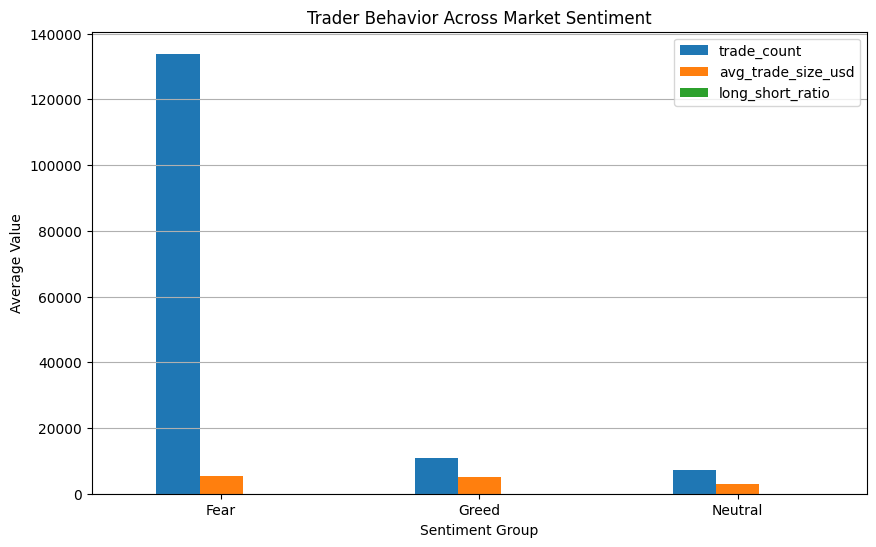

In [13]:
behavior_comparison.plot(
    kind='bar',
    figsize=(10,6)
)

plt.title("Trader Behavior Across Market Sentiment")
plt.xlabel("Sentiment Group")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

### observation
Traders exhibit a massive surge in activity during Fear regimes, with the trade_count (133,871) being over 12 times higher than during Greed (10,812). Interestingly, while the average trade size remains relatively stable (peaking slightly in Fear at $5,260 vs. $4,957 in Greed), the Long/Short Ratio shows a distinct shift: traders are significantly more balanced during Fear (0.975), but develop a much stronger Short Bias during Greed (0.853). This suggests that while traders are most active and perform better during fearful market conditions, they paradoxically become more pessimistic and likely to "bet against" the market during periods of greed.

## Question 3 — Trader Segmentation

### Segment 1: Frequent vs Infrequent Trading Activity

We classify trading periods based on trading frequency to examine
whether higher activity levels lead to different performance outcomes.

In [16]:
# Find median trade activity
trade_threshold = merged_df['trade_count'].median()

# Create activity segment
merged_df['activity_segment'] = np.where(
    merged_df['trade_count'] >= trade_threshold,
    'Frequent Trading',
    'Infrequent Trading'
)

merged_df[['trade_count', 'activity_segment']].head()

,trade_count,activity_segment
0,3,Infrequent Trading
1,1045,Infrequent Trading
2,6962,Infrequent Trading
3,7141,Frequent Trading
4,35241,Frequent Trading


In [31]:
activity_performance = merged_df.groupby('activity_segment').agg({
    'total_pnl': 'mean',
    'win_rate': 'mean',
    'avg_trade_size_usd': 'mean'
}).round(3)

activity_performance

,total_pnl,win_rate,avg_trade_size_usd
activity_segment,,,
Frequent Trading,2529959.487,0.383,5694.188
Infrequent Trading,59040.332,0.255,5625.698


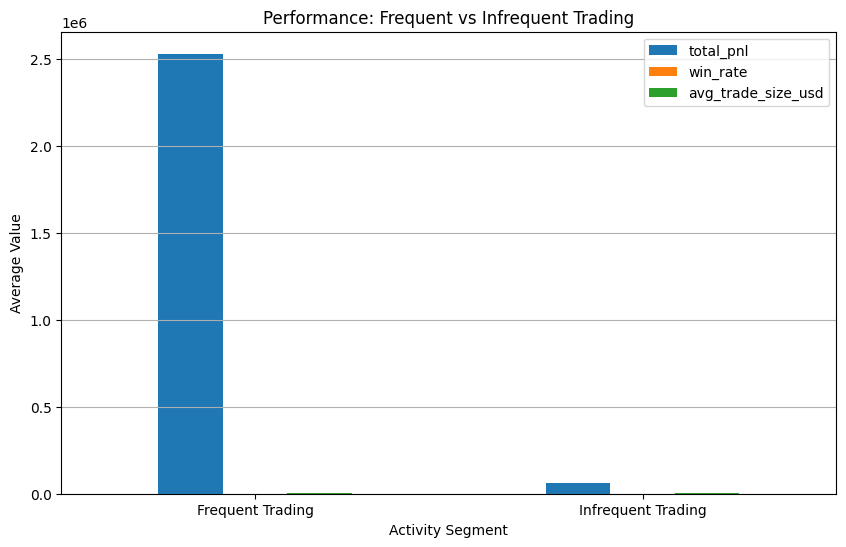

In [32]:
activity_performance.plot(
    kind='bar',
    figsize=(10,6)
)

plt.title("Performance: Frequent vs Infrequent Trading")
plt.xlabel("Activity Segment")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

### observation

The data reveals a stark performance gap between activity levels, where Frequent Traders are the primary drivers of platform profitability, generating a Total PnL of $2,529,959 compared to a mere $59,040 from Infrequent Traders. This massive difference is underpinned by a significantly higher Win Rate (38.3% vs. 25.5%), suggesting that high-frequency participants on Hyperliquid possess a stronger edge or more refined strategies than casual users. Interestingly, the Average Trade Size is almost identical for both groups (~$5,600), indicating that the superior performance of frequent traders is not a result of larger "whale" bets, but rather the compounding effect of higher volume and greater accuracy

### Segment 2:consistent winners vs inconsistent traders

. This segmentation allows us to identify whether the strategies of "Consistent Winners" are more resilient to shifts in market sentiment compared to "Inconsistent Traders."

In [17]:
# Find median win rate
win_threshold = merged_df['win_rate'].median()

# Create consistency segment
merged_df['consistency_segment'] = np.where(
    merged_df['win_rate'] >= win_threshold,
    'Consistent Winners',
    'Inconsistent Traders'
)

# View first 5 rows
merged_df[['win_rate', 'consistency_segment']].head()

,win_rate,consistency_segment
0,0.000000,Inconsistent Traders
1,0.274641,Inconsistent Traders
2,0.490089,Consistent Winners
3,0.317182,Inconsistent Traders
4,0.451605,Consistent Winners


In [18]:
consistency_performance = merged_df.groupby('consistency_segment').agg({
    'total_pnl': 'mean',
    'trade_count': 'mean',
    'avg_trade_size_usd': 'mean'
}).round(3)

consistency_performance

,total_pnl,trade_count,avg_trade_size_usd
consistency_segment,,,
Consistent Winners,2534515.266,50758.750,6344.542
Inconsistent Traders,52965.960,2729.667,4758.559


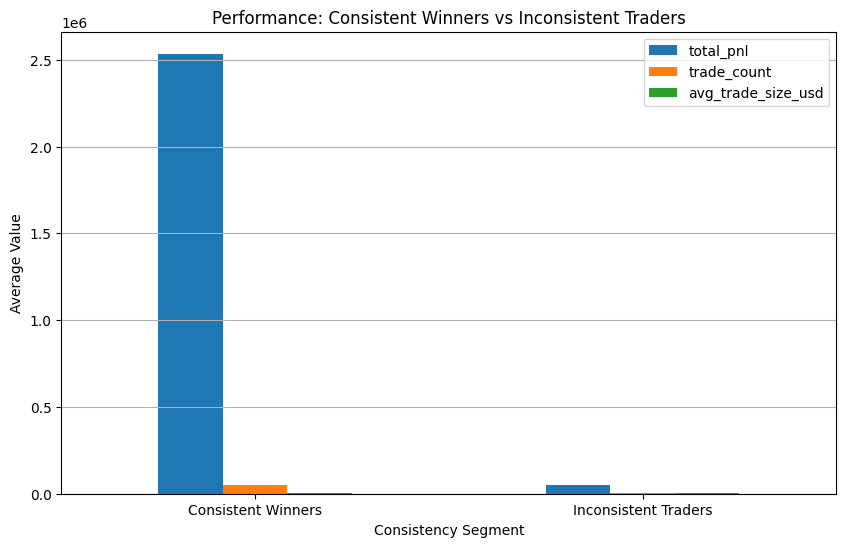

In [19]:
consistency_performance.plot(
    kind='bar',
    figsize=(10,6)
)

plt.title("Performance: Consistent Winners vs Inconsistent Traders")
plt.xlabel("Consistency Segment")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

### Observation: 

The data highlights a profound disparity in performance where Consistent Winners—defined by higher win rates—account for the vast majority of realized profits, totaling $2,534,515 compared to only $52,965 from Inconsistent Traders. This segment is characterized by extreme activity, with an average trade_count of 50,758 per user, which is nearly 18 times higher than their inconsistent counterparts. While Consistent Winners also maintain a larger average trade size (~$6,344 vs. $4,758), the defining factor of their success appears to be the combination of high-frequency execution and a disciplined directional edge. This suggests that on Hyperliquid, the "winner" archetype is not just a lucky participant, but a high-volume, professional-grade trader with a stable strategy.

## FINAL INSIGHTS

# 1. Fear Regimes Drive Peak Profitability & AccuracyThe Data:

 Total PnL during Fear ($6,699,925$) is nearly 8x higher than in Greed ($841,645$), supported by a vastly superior 41.5% win rate.Insight: Market fear is not a deterrent on Hyperliquid; it is the primary "Alpha" generator. The massive surge in trade count suggests that professional traders use fear-driven volatility to execute their most successful and frequent strategies.

# 2. The "Greed" Performance TrapThe Data: 

Win rates hit their lowest point (30.4%) during Greed days, coinciding with the lowest Long/Short ratio (0.853).Insight: Traders exhibit a counter-productive "short bias" when sentiment is greedy. The poor win rate indicates that many are unsuccessfully trying to time market tops (fading the trend), making Greed regimes the most deceptive and risky periods for the average participant.

# 3. Success is a Function of Frequency, Not Just SizeThe Data: 

Consistent Winners maintain an average trade count 18x higher than Inconsistent Traders, yet their average trade size is only roughly 33% larger ($6,344$ vs $4,758$).Insight: Profitability is driven by high-frequency discipline rather than "whale-sized" conviction bets. The platform's winners are "grinders" who utilize high trade volume and consistent execution to compound gains, rather than relying on a few lucky large positions.

## Part C: Actionable Output

# 1. Strategy Idea: Aggressive Liquidity Provision in Fear Regimes

Proposed Action: Increase trade frequency limits and capital allocation for "Frequent/Consistent" segments during Fear days.

Evidence: Data shows Fear days yield 8x higher PnL and a 41% win rate; these segments are best positioned to harvest this Alpha.

# 2. Strategy Idea: Defensive Risk Management in Greed Regimes

Proposed Action: Automatically suggest a 20-30% reduction in leverage for "Inconsistent" traders when sentiment crosses into Greed.

Evidence: Traders currently exhibit their lowest win rates (30%) and a failing short-bias during Greed; this guardrail protects the most vulnerable users from "trend-fading" losses.